## ロジスティック回帰

- 目的変数が（基本的には）2値の質的データ
- 回帰という名前がついているが、分類を行う

In [3]:
import pandas as pd
import seaborn as sns

# Irisデータセットの読み込み
iris = sns.load_dataset('iris')

In [4]:
# 2値データへの分類のため、species から setosa を除外
# - versicolor, virginica の2種だけにした df を作成
df = iris.query('species!="setosa"')

# versicolor, virginica だけになっていることを確認
df

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [5]:
# 0, 50 行目だけを表示して確認
# - 確認のため一部だけを表示
df.iloc[[0, 50]]

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
100,6.3,3.3,6.0,2.5,virginica


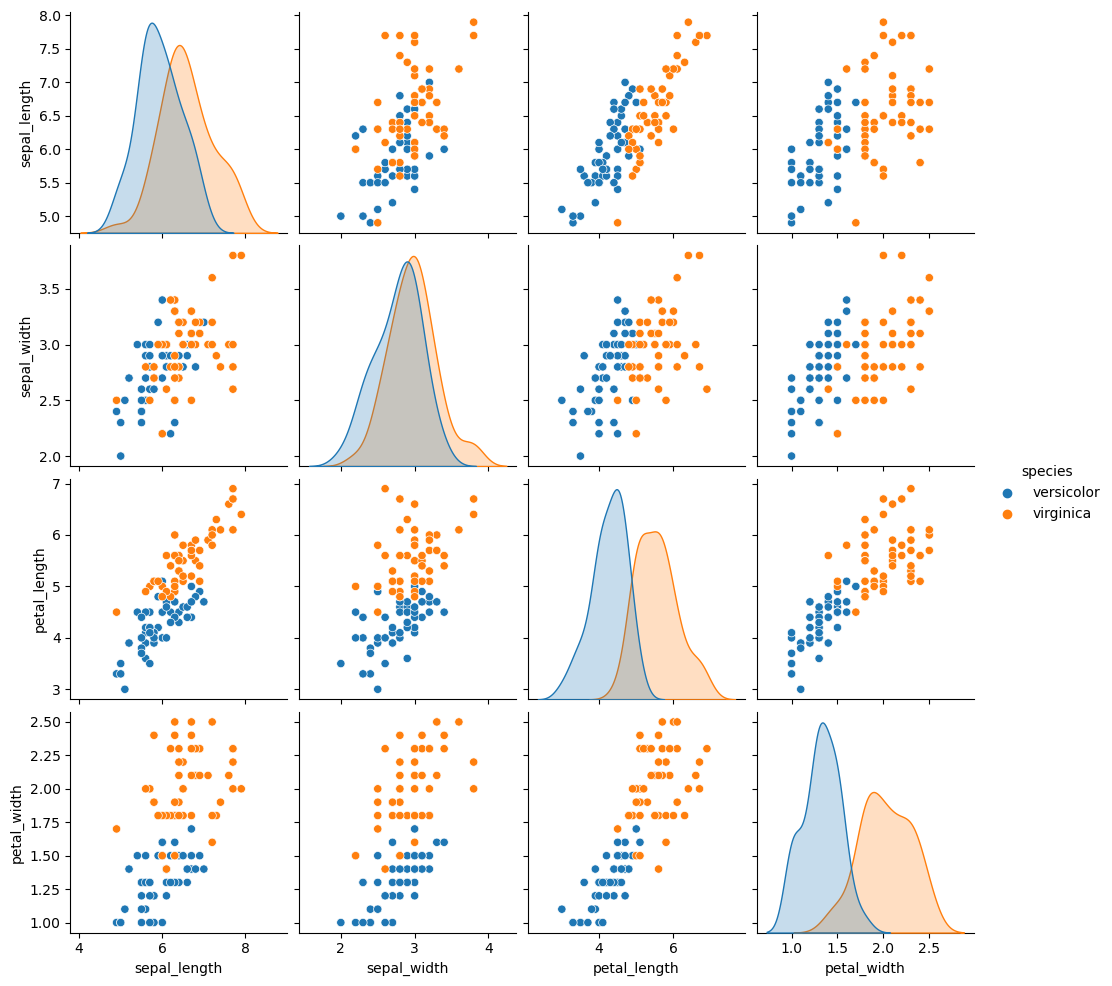

In [6]:
# 散布図でデータの重なりを見る
sns.pairplot(df, hue='species')

上記の散布図で versicolor, virginica の重なり具合を見ると：

- sepal_width は、かなりの重なりがある
- petal_width は、重なりが少なめである

In [7]:
# speciesを 0, 1 にするためにダミー変数化
# - drop_first=True を指定し、1列減らす
#   ここでは、speciesは2種のため、1列のみになる
df = pd.get_dummies(data=df, drop_first=True)

# 確認のため 0, 50 行目を表示
df.iloc[[0, 50]]

,sepal_length,sepal_width,petal_length,petal_width,species_virginica
50,7.0,3.2,4.7,1.4,0
100,6.3,3.3,6.0,2.5,1


<hr>
<img src='slides/6_20.png'>
<hr>

### 一番重なりが少なそうな petal_width を説明変数としてロジスティック回帰モデルを作成する

In [8]:
from sklearn.linear_model import LogisticRegression

X = df[['petal_width']]
Y = df.species_virginica

# ロジスティック回帰モデルを作成、正確度を表示
# - C: 正則化のパラメータ（sklearnのロジスティック回帰はL2正則化がデフォルト）
#      Cを大きくして正則化の影響を小さくする
model = LogisticRegression(C=10000.0)

# 学習
model.fit(X, Y)

# 評価（正確度: Accuracy）
model.score(X, Y)

0.94

Boundary: 1.631655368488691


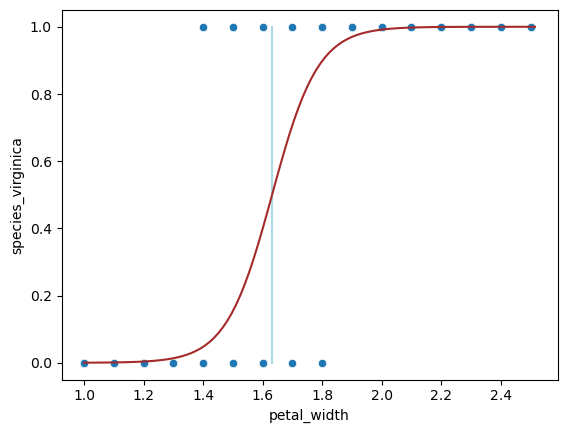

In [9]:
# 散布図にシグモイド曲線を重ねて表示する
import matplotlib.pyplot as plt
import numpy as np

# 標準シグモイド関数の定義
def sigmoid(x, b0, b1):
    return 1/(1 + np.exp(-(b0 + b1 * x)))

# 散布図
sns.scatterplot(x=X.iloc[:,0], y=Y)

# 学習したモデルからパラメータの取得
b0 = model.intercept_[0]
b1 = model.coef_[0][0]

# y=0.5となる分割線
_x = -b0 / b1
plt.plot([_x, _x], [0, 1], color='lightblue')
print('Boundary:', _x)

# シグモイド曲線
_max = X.iloc[:,0].max()
_min = X.iloc[:,0].min()
_step = (_max - _min) / 100
_X = np.arange(_min, _max + _step, _step) # stepで刻んでいく
plt.plot(_X, sigmoid(_X, b0, b1), color='brown')
# 2022年度 (matplotlib 3.5.2) では必要
plt.show()

<hr>
<img src='slides/6_27.png'>
<hr>

In [ ]:
# 教師データについてモデルからの予測値を計算
Y_predict = model.predict(X)
# 混合行列
# - 1行目1列：実際が0、予測が0 (真陰性：TN)
# - 1行目2列：実際が0、予測が1 (偽陽性：FP)
# - 2行目1列：実際が1、予測が0 (偽陰性：FN)
# - 2行目2列：実際が1、予測が1 (真陽性：TP)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(Y, Y_predict)
matrix

In [ ]:
# 散布図では重なりがありデータ数が見えないので確認
# - virginica のうち petal_width < 1.63 のデータ数
df.query('species_virginica==1').query('petal_width<1.63').petal_width.value_counts()

In [ ]:
# 正確度、適合度、再現率（感度）、特異度
# - 特異度の関数は sklearn.metrics には無い
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 特異度 = TN / (FP + TN)
specificity = matrix[0, 0] / (matrix[0, 1] + matrix[0, 0])

print('正確度: {:.3f}, 適合度: {:.3f}, 再現率: {:.3f}, 特異度: {:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), specificity))